<a href="https://colab.research.google.com/github/emmayeh-0211/Team-Topic/blob/main/%E5%B0%88%E9%A1%8C_%E9%A6%99%E8%95%89RandomForest(%E7%89%B9%E5%BE%B5%E5%B7%A5%E7%A8%8B_%E5%A4%A9%E6%B0%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


index：日期
input data：批發市場交易量、每日天氣、颱風警報
output answer：批發市場每日交易價格

In [ ]:
import pandas as pd
from IPython.display import display
# 資料來自個地方
w_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/氣候資料/各縣市氣候資料_0701/dataset.csv'
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/市場批發交易歷史資料/農產品原始價格 (未整理)/香蕉價格(8901-11006).xlsx'
weather_df = pd.read_csv(w_file_path) # 氣候資料
weather_df.set_index(["date"], inplace=True)
price_df = pd.read_csv(p_file_path) # 香蕉的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
display(weather_df.tail())
display(price_df.head())


In [ ]:
# 先進行批發市場交易價格特性分析
import pandas as pd
from IPython.display import display
# 資料來源
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/市場批發交易歷史資料/農產品原始價格 (未整理)/香蕉價格(8901-11006).xlsx'
price_df = pd.read_excel(p_file_path, columns=5) # 香蕉的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
display(weather_df.tail())
display(price_df.head())


先處理市場批發交易資料：Date、Market、product、Up_price、Mid_price、Low_price、	Avg_price、Volume、Month、Week_day、Year、Rest_day。


---
* 抓出不含休市資料的表格（使用loc不用drop）
* 加入前7天的市場交易資訊（不包含休市了，因此若中間日期有休市日會自動跳過）
* 加入累積7天平均交易資訊
* 加入要預測日的均價（3天後的均價）



In [ ]:
# 將市場資料中的
filter = price_df.Rest_day == 0 # 休市日標記為0
indexNames = price_df[filter].index # 符合filter的index們
newprice_df = price_df.loc[indexNames,:] # 使用新的df
newprice_df.Rest_day.value_counts() # 休市日部分只剩下標注為0的資料了

0    6500
Name: Rest_day, dtype: int64

In [ ]:
# # 加入前6天的交易資訊
# for day in range(1, 7):
#   columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
#   temp_df = newprice_df.loc[:, columns]
#   shifted_df=temp_df.shift(periods=day)
#   shifted_df = shifted_df.add_suffix('_' + str(day) + 'days_ago')
#   newprice_df = pd.merge(newprice_df, shifted_df, how='outer', left_index=True, right_index=True)
# newprice_df

In [ ]:
# # 加入過去一周價格資料的平均
# # 方法二，把上面找到的資料加起來做平均
# columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
# for c in columns:
#   c_list = list()
#   for w in newprice_df.columns:
#     if c in w:
#       c_list.append(w)
#   temp_df = newprice_df.loc[:, c_list]
#   display(temp_df)
#   newprice_df[c + '_mean'] = temp_df.mean(axis=1)
# newprice_df.tail()

In [ ]:
# 要預測的答案為3天後的價格，因此把3天後的價格加入
shifted_df=newprice_df.Avg_price.shift(periods=-3)
newprice_df['ans_price'] = shifted_df
newprice_df.loc[:,['Avg_price', 'ans_price']].tail(10)

,Avg_price,ans_price
Date,,
2021-06-08,24.4,25.1
2021-06-09,23.5,25.3
2021-06-10,25.8,26.1
2021-06-11,25.1,26.6
2021-06-12,25.3,23.2
2021-06-13,26.1,20.9
2021-06-14,26.6,24.8
2021-06-17,23.2,NaN
2021-06-18,20.9,NaN


In [ ]:
# # 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# # 縣市只挑選香蕉主要產地：高雄、屏東、南投、台南、台中、彰化、台東 7個縣市
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
# citys = ['KHH', 'IUH', 'NTO', 'TXG', 'CWH', 'TNN', 'TTT']
# keep = ['WarnMark']
# for c in citys:
#   for w in weather_df:
#     if c in w:
#       for f in factors:
#         if f in w:
#           keep.append(w)
# weather_df = weather_df.loc[:, keep]
# weather_df.tail()

In [ ]:
# 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# 縣市：先放所有縣市
factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
keep = ['WarnMark']
for w in weather_df:
    for f in factors:
      if f in w:
        keep.append(w)
weather_df = weather_df.loc[:, keep]
weather_df.tail()

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean(O)
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'Temperature' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_mean_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].mean(axis=0)
  d = d.add_suffix('_mean_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max(O)
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'T_Max' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_max_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].max(axis=0)
  d = d.add_suffix('_max_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min(O)
# 雨量 過去90天累積雨量 sum
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'T_Min' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_min_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].min(axis=0)
  d = d.add_suffix('_min_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum(O)
# factors = ['Temperature', 'T_Max', 'T_Min', 'WS_', 'WSGust', 'Precp_']
c_list=list()
name_list=list()
for num, name in enumerate(weather_df.columns):
  if 'Precp_' in name:
    c_list.append(num)
    name_list.append(name)

white_df = pd.DataFrame(index=weather_df.index,columns=name_list)
white_df = white_df.add_suffix('_sum_of_90days')
for start in range(len(weather_df.index)):
  d = weather_df.iloc[start:start+89,c_list].sum(axis=0)
  d = d.add_suffix('_sum_of_90days')
  white_df.iloc[start]=d
weather_df = pd.merge(weather_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內

In [ ]:
display(weather_df.head())
display(weather_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0,22.0,1.9,8.3,0.0,21.3,1.6,8.9,0.0,9.0,7.5,14.1,0.0,19.3,3.6,10.0,0.0,19.3,2.538,8.883,0.0,19.5,2.3,11.1,0.0,19.2,1.8,7.2,0.0,20.5303,20.6629,7.78876,16.9404,16.9404,18.2584,17.1427,101.8,77,350.5,475.6,148,38.8,206.8
2000-01-02,0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,18.7,4.0,13.4,0.0,18.7,2.115,9.306,0.0,18.6,1.6,8.5,0.0,17.9,2.8,11.4,0.0,20.5506,20.6764,7.81573,16.964,16.964,18.2876,17.1326,101.8,77,350.5,475.6,148,38.8,206.9
2000-01-03,0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,18.2,2.1,13.5,0.0,18.2,2.679,14.241,0.0,18.3,1.4,6.9,0.0,16.9,2.2,9.8,0.0,20.5978,20.7045,7.83708,17.0169,17.0169,18.3472,17.1506,101.8,78.9,350.5,475.6,148,38.8,212.3
2000-01-04,0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,17.5,1.6,7.2,0.0,17.5,2.538,13.677,0.0,17.7,1.6,6.1,0.2,17.2,1.5,5.9,0.0,20.6494,20.7506,7.8764,17.0663,17.0663,18.3989,17.1944,145.6,88.9,425.9,540.5,204,92.6,225.5
2000-01-05,0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,18.8,1.7,10.8,0.0,18.8,2.256,11.280,0.0,19.8,1.3,6.1,0.2,19.5,1.4,7.3,0.2,20.7067,20.8022,7.94045,17.1236,17.1236,18.4719,17.2472,145.5,89.1,426,540.5,204,92.4,227.7


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0,28.36,27.52,22.16,25.96,29.38,28.64,27.96,51.9,45,19.2,17.3,20.5,44.3,0
2021-06-15,0,29.0,1.3,6.2,5.2,27.7,2.4,9.7,4.9,22.8,1.7,7.7,0.7,26.3,2.3,8.4,0.2,29.7,2.1,7.7,0.5,28.9,1.5,6.7,4.8,27.5,2.0,9.4,0.0,28.1,27.35,22.05,25.95,29.35,28.45,28.15,51.8,44.6,18.8,17.1,20.5,44.3,0
2021-06-16,0,27.3,1.3,7.4,26.7,26.6,2.9,11.5,30.1,21.2,1.8,7.6,12.2,25.0,2.2,9.4,16.0,28.3,2.0,7.3,17.8,27.9,1.6,7.9,26.6,28.3,2.3,10.4,0.0,27.8,27.2333,21.8,25.8333,29.2333,28.3,28.3667,46.6,39.7,18.1,16.9,20,39.5,0
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0,28.05,27.55,22.1,26.25,29.7,28.5,28.4,19.9,9.6,5.9,0.9,2.2,12.9,0
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0,28.2,27.7,22.3,26.3,29.9,28.9,28.4,10.9,4.3,1.4,0.7,2.1,4,0


In [ ]:
# 合併 天氣因素表格&批發市場價格表格
# how的部分改為inner，因為價格部分不是每天都有，變成以兩個表格都有的資料再做合併
new_df = pd.merge(weather_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
display(new_df.head())
display(new_df.tail())

,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days,ans_price
2000-01-02,0,21.0,1.7,5.8,0.0,21.1,3.3,13.3,0.0,8.3,6.5,13.1,0.0,18.7,4.0,13.4,0.0,18.7,2.115,9.306,0.0,18.6,1.6,8.5,0.0,17.9,2.8,11.4,0.0,20.5506,20.6764,7.81573,16.964,16.964,18.2876,17.1326,101.8,77,350.5,475.6,148,38.8,206.9,20.0
2000-01-03,0,20.6,1.8,7.0,0.0,20.7,2.9,13.0,0.1,6.3,6.4,14.8,0.0,18.2,2.1,13.5,0.0,18.2,2.679,14.241,0.0,18.3,1.4,6.9,0.0,16.9,2.2,9.8,0.0,20.5978,20.7045,7.83708,17.0169,17.0169,18.3472,17.1506,101.8,78.9,350.5,475.6,148,38.8,212.3,20.3
2000-01-04,0,20.8,1.9,6.5,0.1,20.8,2.2,9.2,0.0,5.7,6.1,12.3,0.0,17.5,1.6,7.2,0.0,17.5,2.538,13.677,0.0,17.7,1.6,6.1,0.2,17.2,1.5,5.9,0.0,20.6494,20.7506,7.8764,17.0663,17.0663,18.3989,17.1944,145.6,88.9,425.9,540.5,204,92.6,225.5,20.2
2000-01-05,0,22.4,1.6,4.9,0.2,22.4,1.5,5.8,0.0,6.9,4.0,13.2,0.0,18.8,1.7,10.8,0.0,18.8,2.256,11.280,0.0,19.8,1.3,6.1,0.2,19.5,1.4,7.3,0.2,20.7067,20.8022,7.94045,17.1236,17.1236,18.4719,17.2472,145.5,89.1,426,540.5,204,92.4,227.7,19.6
2000-01-06,0,21.9,1.2,4.9,0.1,21.9,2.4,10.1,1.6,7.1,4.8,12.0,0.0,19.7,3.1,12.5,0.0,19.7,1.551,9.306,0.0,20.2,1.2,5.3,0.0,18.5,2.0,8.7,3.2,20.7494,20.8371,7.98202,17.1663,17.1663,18.5292,17.2674,145.4,89.2,429.1,550.2,208.9,92.3,227.8,20.1


,WarnMark,Temperature_KHH,WS_KHH,WSGust_KHH,Precp_KHH,Temperature_IUH,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_NTO,WS_NTO,WSGust_NTO,Precp_NTO,Temperature_TXG,WS_TXG,WSGust_TXG,Precp_TXG,Temperature_CWH,WS_CWH,WSGust_CWH,Precp_CWH,Temperature_TNN,WS_TNN,WSGust_TNN,Precp_TNN,Temperature_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_TTT_mean_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_TNN_sum_of_90days,Precp_TTT_sum_of_90days,ans_price
2021-06-12,0,28.9,1.6,9.3,9.6,27.5,1.8,9.1,6.5,21.9,1.5,8.4,22.1,25.2,1.4,8.5,18.3,28.7,1.4,10.5,16.9,28.4,1.4,8.3,12.4,26.0,1.1,6.0,6.3,28.5571,27.5857,22.1143,25.8,29.2571,28.7,27.4714,71.9,59,51.5,36.6,37.4,60.7,8.8,23.2
2021-06-13,0,29.2,1.5,6.9,10.4,28.0,1.4,6.8,7.5,22.1,1.6,7.7,10.2,25.6,1.7,7.3,1.0,29.2,1.4,6.3,0.0,29.3,1.4,6.9,4.0,26.5,1.1,6.3,2.5,28.5,27.6,22.15,25.9,29.35,28.75,27.7167,62.3,52.5,29.4,18.3,20.5,48.3,2.5,20.9
2021-06-14,0,29.4,1.6,7.5,0.1,28.2,2.7,10.1,0.4,22.6,1.6,7.4,0.4,26.0,1.9,8.0,0.2,29.5,1.6,7.1,0.0,29.4,1.4,6.9,0.0,27.2,1.6,7.4,0.0,28.36,27.52,22.16,25.96,29.38,28.64,27.96,51.9,45,19.2,17.3,20.5,44.3,0,24.8
2021-06-17,0,27.9,1.3,7.0,9.0,27.4,2.8,11.0,5.3,21.9,1.8,7.7,4.5,26.2,2.4,9.2,0.2,29.5,2.3,8.3,0.1,28.1,1.5,7.3,8.9,28.4,2.0,9.0,0.0,28.05,27.55,22.1,26.25,29.7,28.5,28.4,19.9,9.6,5.9,0.9,2.2,12.9,0,NaN
2021-06-18,0,28.2,1.2,7.1,10.9,27.7,2.9,11.3,4.3,22.3,1.8,7.5,1.4,26.3,2.3,9.0,0.7,29.9,2.3,8.7,2.1,28.9,1.4,6.7,4.0,28.4,1.8,7.9,0.0,28.2,27.7,22.3,26.3,29.9,28.9,28.4,10.9,4.3,1.4,0.7,2.1,4,0,NaN


In [ ]:
# 尋找空值
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

ans_price    2
dtype: int64

In [ ]:
# 另外因為只有針對單一市場跟作物，因此不需要 Market 跟 Product 兩個欄位了，使用drop方式移除，然後也不需要rest day了
# 另外應該也不能放上中下價，也先移除
new_df = new_df.drop(columns=['Market', 'Product', 'Rest_day'], axis=1)
display(new_df.head())
display(new_df.tail())

In [ ]:
# 前後有空值，丟棄空值的資料
new_df.dropna(axis=0, how='any', inplace=True)


In [ ]:
# 尋找空值，要無空值才是正常
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [ ]:
# 先將跨模組的驗證資料切割出來，以2020-06-01以後的資料作為 測試資料
test_df = new_df.loc['2020-06-01':,:] # 測試資料
merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
display(merge_df.tail())
display(test_df.head())

In [ ]:
# 將資料切割為訓練集&驗證集，時序不能重疊到，hen難懂(攤手)
# 最簡單的方法，用時間來切割 訓練集跟驗證集，即可避免時序重疊 9 / 1 切，驗證集資料約為620筆
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
  
merge_df = clean_dataset(merge_df)

train_df = merge_df.iloc[:-600]
valid_df = merge_df.iloc[-600:]
display(train_df.tail())
display(valid_df.head())



In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸

In [ ]:
# 轉成np array
x_train, y_train = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])
x_test, y_test = np.array(valid_df.drop(['ans_price'], axis=1)), np.array(valid_df['ans_price'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
c_df = train_df.drop(['ans_price'], axis=1)

In [ ]:
from sklearn.feature_selection import SelectFromModel 
estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
sfm_selector = SelectFromModel(estimator) 
sfm_selector.fit(x_train, y_train) 
c_df.columns[sfm_selector.get_support()] 


In [ ]:
# import numpy as np
# from sklearn.model_selection import cross_val_score # 交叉驗證
# from sklearn.model_selection import GridSearchCV 
# from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
# # 隨機森林可以放入不同參數來去調整模型，透過GridSearchCV可以將各種可能的參數放進去來找出最好的分數跟參數
# # GridSearchCV會跑非常久，超過1hr

# params = {
#     "n_estimators":range(85, 100),
#     "max_depth":range(9, 11)
# }
# clf = RandomForestRegressor()
# cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
# cv.fit(x_train, y_train)
# print(cv.best_score_)
# print(cv.best_params_)

In [ ]:
clf = RandomForestRegressor(n_estimators=93, max_depth=10)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10:", scores)
print("average:", np.average(scores))

10: [0.77837237 0.72659188 0.77973506 0.78043811 0.72070725 0.77504772
 0.76490871 0.74912968 0.72189433 0.78343184]
average: 0.7580256949128539


In [ ]:
# # 將模型儲存起來，注意命名的部分
# from sklearn.externals import joblib
# joblib.dump(clf,'/content/drive/MyDrive/AI課程檔案/專題相關/clf0710_ver9.pkl') 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/MyDrive/AI課程檔案/專題相關/clf0710_ver9.pkl']

In [ ]:
# clf = joblib.load('路徑') # 將模型叫出來的方式
pre = clf.predict(x_test)
result_df = pd.DataFrame({
    "data_price":y_test,
    "predict_price":pre
})
result_df

,data_price,predict_price
0,17.1,18.474926
1,12.6,17.064559
2,40.9,29.687041
3,19.2,23.626788
4,9.7,10.086223
...,...,...
645,18.0,27.257486
646,37.4,30.225737
647,33.6,28.336088
648,17.7,23.877346


In [ ]:
from sklearn.metrics import r2_score
pre = clf.predict(x_test)
r2_score(y_test, pre)

0.7806768812659874

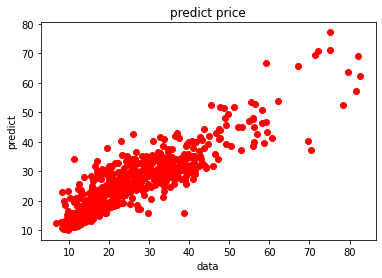

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, pre, c="red")
plt.xlabel("data")
plt.ylabel("predict")
plt.title("predict price")
plt.show()

[Text(279.0, 475.65000000000003, 'Temperature_TXG <= 25.35\nmse = 183.144\nsamples = 3673\nvalue = 25.633'),
 Text(139.5, 339.75, 'WS_NTO <= 2.75\nmse = 201.501\nsamples = 2281\nvalue = 29.518'),
 Text(69.75, 203.85000000000002, 'WSGust_IUH <= 9.45\nmse = 227.849\nsamples = 1390\nvalue = 34.063'),
 Text(34.875, 67.94999999999999, '\n  (...)  \n'),
 Text(104.625, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 203.85000000000002, 'WS_NTO <= 4.05\nmse = 84.354\nsamples = 891\nvalue = 22.694'),
 Text(174.375, 67.94999999999999, '\n  (...)  \n'),
 Text(244.125, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 339.75, 'Temperature_NTO <= 18.85\nmse = 87.395\nsamples = 1392\nvalue = 19.248'),
 Text(348.75, 203.85000000000002, 'Precp_KHH_sum_of_90days <= 86.45\nmse = 53.344\nsamples = 920\nvalue = 16.418'),
 Text(313.875, 67.94999999999999, '\n  (...)  \n'),
 Text(383.625, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 203.85000000000002, 'Precp_IUH_sum_of_90days <= 304.05\nmse = 107.

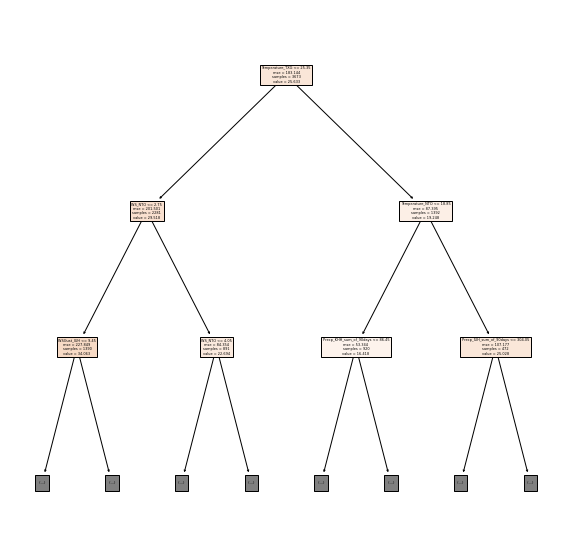

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
features = new_df.drop(['ans_price'], axis=1).columns
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[2], 
          feature_names=features, 
          class_names=['predict_price'],
          max_depth=2,
          filled=True)

In [ ]:
result_df = pd.DataFrame({
    "Name":features,
    "Importance":clf.feature_importances_
}).sort_values(by="Importance", ascending=False)
display(result_df[:10])

,Name,Importance
13,Temperature_TXG,0.161701
10,WS_NTO,0.135166
37,Precp_IUH_sum_of_90days,0.093208
38,Precp_NTO_sum_of_90days,0.081700
42,Precp_TTT_sum_of_90days,0.053218
9,Temperature_NTO,0.047403
36,Precp_KHH_sum_of_90days,0.040088
7,WSGust_IUH,0.039975
40,Precp_CWH_sum_of_90days,0.039640
35,Temperature_TTT_mean_of_90days,0.035933


In [ ]:
factors = {'Temperature':'溫度', 'T_Max':'最高溫', 'T_Min':'最低溫', 'WS_':'風速', 'WSGust':'最大陣風', 'Precp_':'雨量'}
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

for i in result_df.index:
  title = result_df.Name[i]
  for key, value in factors.items():
    if key in title:
      title = title.replace(key, value)
  for key, value in city.items():
    if value in title:
      title = title.replace(value, key)
  result_df.loc[[i], ['Name']]=title
result_df

,Name,Importance
13,溫度_臺中市,0.161701
10,風速南投縣,0.135166
37,雨量屏東縣_sum_of_90days,0.093208
38,雨量南投縣_sum_of_90days,0.081700
42,雨量臺東縣_sum_of_90days,0.053218
9,溫度_南投縣,0.047403
36,雨量高雄市_sum_of_90days,0.040088
7,最大陣風_屏東縣,0.039975
40,雨量彰化縣_sum_of_90days,0.039640
35,溫度_臺東縣_mean_of_90days,0.035933


In [ ]:
pd.set_option('display.max_row', None)
result_df

,Name,Importance
13,Temperature_TXG,0.161701
10,WS_NTO,0.135166
37,Precp_IUH_sum_of_90days,0.093208
38,Precp_NTO_sum_of_90days,0.081700
42,Precp_TTT_sum_of_90days,0.053218
9,Temperature_NTO,0.047403
36,Precp_KHH_sum_of_90days,0.040088
7,WSGust_IUH,0.039975
40,Precp_CWH_sum_of_90days,0.039640
35,Temperature_TTT_mean_of_90days,0.035933


In [ ]:
# # 儲存上面表格的檔案
# result_df.to_csv('/content/drive/MyDrive/AI課程檔案/專題相關/重要性(clf0710_ver9).csv')

In [ ]:
# 預測自己設定的年份，預計預測2020-2021年的數據資料
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import numpy as np
temp_df = new_df[-365:]
a, b = np.array(temp_df.drop(['ans_price'], axis=1)), np.array(temp_df['ans_price'])
pre = clf.predict(a)
result_df = pd.DataFrame({
    "data_price":b,
    "predict_price":pre
})
print('r2 score:', r2_score(b, pre))
display(result_df.head())

r2 score: 0.36325738282487996


,data_price,predict_price
0,34.5,33.598957
1,35.1,35.133039
2,36.3,35.291238
3,34.9,32.193886
4,34.9,32.900743


In [ ]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.plot(temp_df.index, temp_df.Avg_price, label = "data")
plt.plot(temp_df.index, pre, label = "predict")
plt.title("2020-2021 price") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label
plt.legend() # 圖例的說明
plt.show()

AttributeError: ignored